# Project \#3 - Face generation

### Deep Learning course -  A.Y. 2019-2020

Students:
- Simone Gayed Said
- Pierpasquale Colagrande


## Import of fundamental libraries
Herw we import fundamental libraries as TensorFlow, Numpy etc.

In [0]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Flatten, Dense, Reshape, Concatenate, GlobalAveragePooling2D, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import os
print("TensorFlow version", tf.__version__)

TensorFlow version 2.2.0-rc4


Using TensorFlow backend.



## Input pipeline

Our input data is stored on Google Cloud Storage. To more fully use the parallelism TPUs offer us, and to avoid bottlenecking on data transfer, we've stored our input data in TFRecord files, 2025 images per file.

Below, we make heavy use of `tf.data.experimental.AUTOTUNE` to optimize different parts of input loading.


In [0]:
BATCH_SIZE = 128
BUFFER_SIZE = 60000
ORIGINAL_IMAGE_SIZE = [218, 178, 3]
TARGET_IMAGE_SIZE = [64, 64, 3]

In [0]:
AUTO = tf.data.experimental.AUTOTUNE

gcs_pattern = 'gs://celeba-public/tfrecord_*.tfrec'

filenames = tf.io.gfile.glob(gcs_pattern)

feature_dict = {
      "image": tf.io.FixedLenFeature([], tf.string),
  }


def parse_tfrecord(example):
  features = feature_dict
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_image(example['image'])  
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(normalized, [ORIGINAL_IMAGE_SIZE[0], ORIGINAL_IMAGE_SIZE[1], ORIGINAL_IMAGE_SIZE[2]])
  image_tensor = tf.image.resize(image_tensor[45:173,25:153], (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1])) # crop and reshape the image 
  return image_tensor, image_tensor # Adding a fake label

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

labeled_ds = load_dataset(filenames)

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTO)

  return ds

train_dataset = prepare_for_training(labeled_ds, shuffle_buffer_size = BUFFER_SIZE)

Let's take a peek at the dataset we've created:

In [0]:
def show_batch(image_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

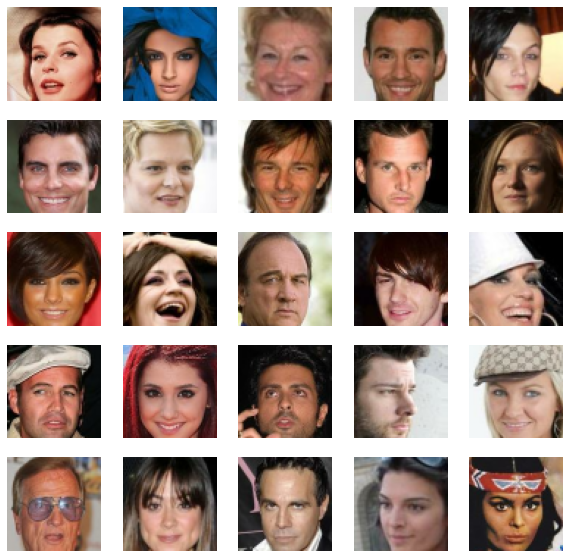

In [6]:
import tensorflow_datasets as tfds
train_ds = prepare_for_training(labeled_ds)
#numpy_imgs, label_batch = next(tfds.as_numpy(train_ds))
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy())
#show_batch(numpy_imgs)

## Network model
Here, we build the network model.

In [0]:
Z_DIM = 64

In [0]:
# ENCODER
def create_encoder(image_size, latent_size):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()

  encoder_input = Input(shape = image_size, name = 'encoder_input')
  shape_before_flattening = K.int_shape(encoder_input)[1:] 
  x = Flatten()(encoder_input)
  mu = Dense(latent_size, name = 'mu')(x)
  log_sigma = Dense(latent_size, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mu, log_sigma = args
    epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.) 
    return mu + K.exp(log_sigma/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer 
  # in the model
  encoder_output = Lambda(sampling, name='encoder_output')([mu, log_sigma])

  return encoder_input, encoder_output, mu, log_sigma, shape_before_flattening

In [0]:
def create_decoder(latent_size):
  decoder_input = Input(shape = (latent_size,) , name = 'decoder_input')
  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)
  # Define model output
  decoder_output = x
  decoder = Model(decoder_input, decoder_output)
  return decoder


In [0]:
encoder_input, encoder_output, mu, log_sigma, shape_before_flattening = create_encoder(TARGET_IMAGE_SIZE,Z_DIM)
decoder = create_decoder(Z_DIM)

In [0]:
LEARNING_RATE = 0.0005
N_EPOCHS = 50
LOSS_FACTOR = 10000
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(y_true, y_pred):
    kl_loss = -0.5 * K.sum(1 + log_sigma - K.square(mu) - K.exp(log_sigma), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

In [0]:
vae_input = encoder_input
vae_output = decoder(encoder_output)
vae_model = Model(vae_input, vae_output)
adam_optimizer = Adam(lr = LEARNING_RATE)
vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

In [18]:
dataset = tfds.as_numpy(train_dataset)
vae_model.fit(dataset, shuffle=True, 
                        epochs = N_EPOCHS, 
                        initial_epoch = 0, 
                        steps_per_epoch=202599 // BATCH_SIZE)

Epoch 1/50
1582/1582 [==============================] - 20s 12ms/step - loss: 173.2104 - r_loss: 0.0118 - kl_loss: 55.0914
Epoch 2/50
1582/1582 [==============================] - 19s 12ms/step - loss: 173.4161 - r_loss: 0.0118 - kl_loss: 55.1384
Epoch 3/50
1582/1582 [==============================] - 19s 12ms/step - loss: 173.2505 - r_loss: 0.0118 - kl_loss: 55.0400
Epoch 4/50
1582/1582 [==============================] - 19s 12ms/step - loss: 173.3209 - r_loss: 0.0118 - kl_loss: 55.0217
Epoch 5/50
1582/1582 [==============================] - 19s 12ms/step - loss: 172.9027 - r_loss: 0.0118 - kl_loss: 54.9136
Epoch 6/50
1582/1582 [==============================] - 19s 12ms/step - loss: 173.1437 - r_loss: 0.0118 - kl_loss: 54.9301
Epoch 7/50
1582/1582 [==============================] - 19s 12ms/step - loss: 172.9413 - r_loss: 0.0118 - kl_loss: 54.8685
Epoch 8/50
1582/1582 [==============================] - 19s 12ms/step - loss: 172.9474 - r_loss: 0.0118 - kl_loss: 54.8460
Epoch 9/50
1582/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

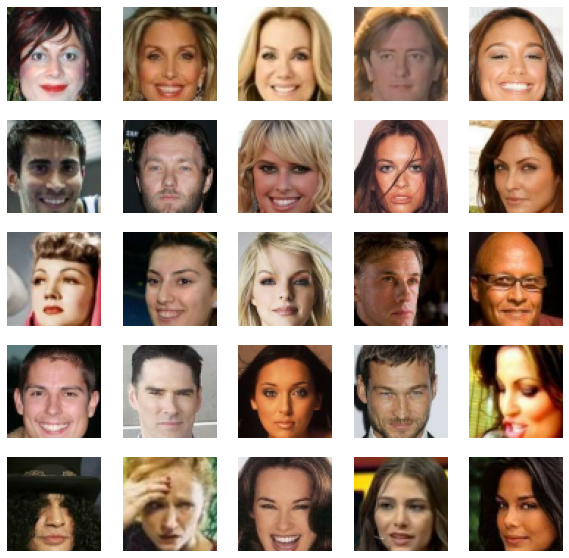

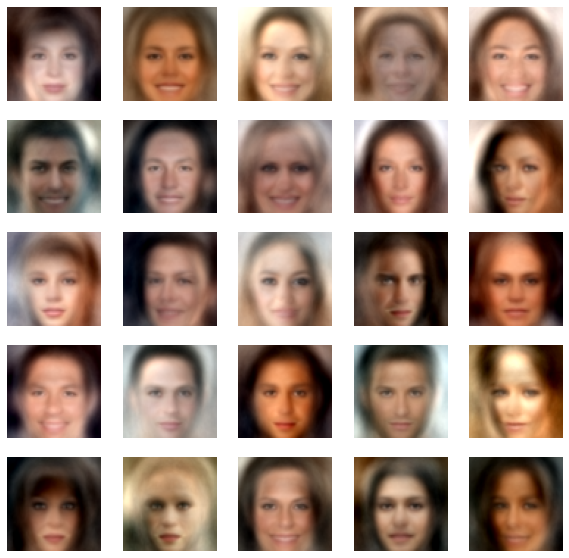

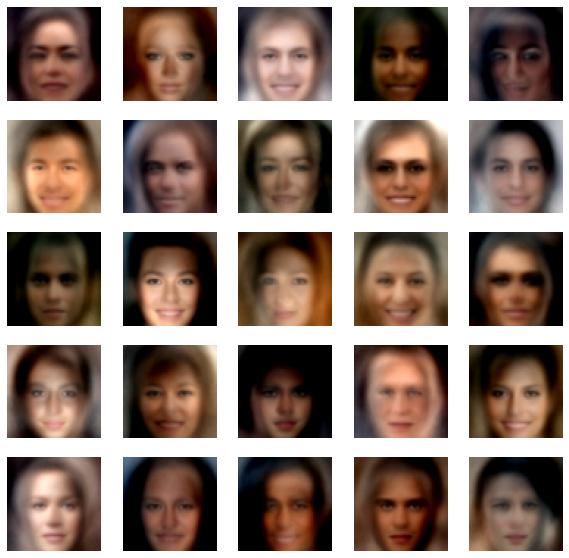

In [20]:
image_batch, label_batch = next(iter(dataset))
predictions = vae_model.predict(image_batch)
show_batch(image_batch)
show_batch(predictions)
predictions = decoder.predict(np.random.normal(0,1,size=(25,Z_DIM)))
show_batch(predictions)